# **Idly, vada, dosa classifer**

**Task**: Build and deploy idly/vada/dosa classifer

- Procure 10,000 images each of Idly, Dosa and Vada from Internet
    - Learn and document how you procured those images
- Build a CNN model from scratch
- Use pre-trained model (resnet-50) + finetune only the last layer
- Use pre-trained model + finetune last few layers
- Build ViT model
- Deploy the best performing model as API. Sign up to GCP, it will give you $300 free credits. Deploy the API there.
    - Input: image
    - output: probability for each of the three classes

- Report precision and recall for all of the models
- Push code to Github. Share the github repo for review. It should be well documented.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First, I have taken 500 images for each classes and doing the pre-processing.


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2

data_dir ='/content/drive/MyDrive/Food Classification'

images = []
labels = []

print("Count of each Classes: ")
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        label = str(folder)
        print(label,":",len(os.listdir(folder_path)))
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            img = cv2.imread(image_path)

            #pre-procesing the image by resizing it to (96, 96) and normalizing pixel values
            img = cv2.resize(img, (96, 96))
            img = img.astype(np.float32) / 255.0

            images.append(img)
            labels.append(label)


Count of each Classes: 
idli : 472
vada : 437
dosa : 543


In [ ]:
len(images)

1452

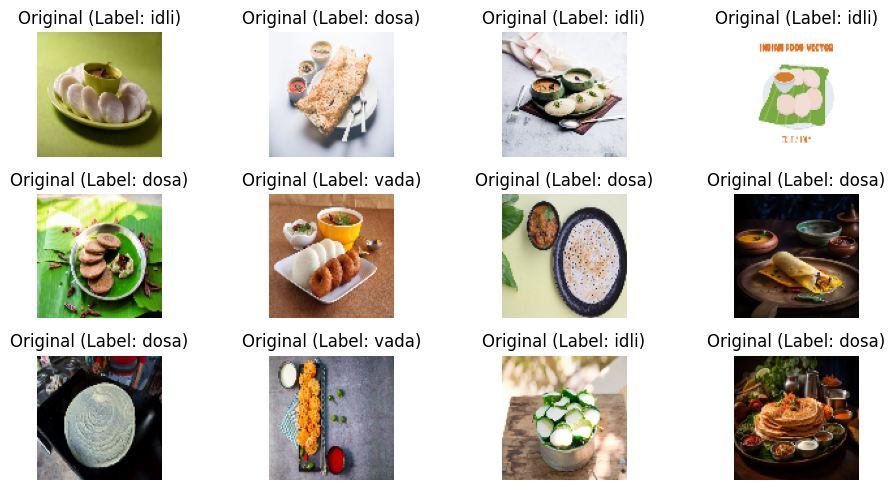

In [ ]:
import matplotlib.pyplot as plt
import random

#Displaying the random sample of images
num_rows = 3
num_cols = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5))
indices_to_display = random.sample(range(len(images)), num_rows * num_cols)

for i, ax in enumerate(axes.flat):
    idx = indices_to_display[i]
    original_img = images[idx]
    label = labels[idx]

    # Converting BGR to RGB
    rgb_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    ax.imshow(rgb_img)
    ax.set_title(f'Original (Label: {label})')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Displaying the mapping of original labels to encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)


images = np.array(images)
labels = np.array(labels)


X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

Label Mapping: {'dosa': 0, 'idli': 1, 'vada': 2}


In [ ]:
import torch

# Converting NumPy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).permute(0, 3, 1, 2).float()
X_test_tensor = torch.from_numpy(X_test).permute(0, 3, 1, 2).float()

y_train_tensor = torch.from_numpy(y_train).long()
y_test_tensor = torch.from_numpy(y_test).long()


# 1. Building a CNN model from scratch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(512 * 6 * 6, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 512 * 6 * 6)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x


# Moving the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
model = CustomCNN().to(device)

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Converting data to PyTorch DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Training the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluation on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [1/50], Loss: 1.0708, Accuracy: 0.3746
Epoch [2/50], Loss: 1.0648, Accuracy: 0.3746
Epoch [3/50], Loss: 1.1277, Accuracy: 0.3746
Epoch [4/50], Loss: 1.1323, Accuracy: 0.3746
Epoch [5/50], Loss: 1.0590, Accuracy: 0.3746
Epoch [6/50], Loss: 1.0045, Accuracy: 0.3746
Epoch [7/50], Loss: 1.0881, Accuracy: 0.4055
Epoch [8/50], Loss: 1.0914, Accuracy: 0.4089
Epoch [9/50], Loss: 0.9649, Accuracy: 0.4192
Epoch [10/50], Loss: 1.0493, Accuracy: 0.4296
Epoch [11/50], Loss: 1.1449, Accuracy: 0.4364
Epoch [12/50], Loss: 1.1398, Accuracy: 0.4192
Epoch [13/50], Loss: 1.0702, Accuracy: 0.4330
Epoch [14/50], Loss: 0.8801, Accuracy: 0.4674
Epoch [15/50], Loss: 0.6748, Accuracy: 0.4502
Epoch [16/50], Loss: 0.6902, Accuracy: 0.5189
Epoch [17/50], Loss: 0.5913, Accuracy: 0.4948
Epoch [18/50], Loss: 0.9280, Accuracy: 0.5155
Epoch [19/50], Loss: 0.8184, Accuracy: 0.4742
Epoch [20/50], Loss: 0.6494, Accuracy: 0.4674
Epoch [21/50], Loss: 0.5615, Accuracy: 0.5189
Epoch [22/50], Loss: 0.5084, Accuracy: 0.47

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/basic_cnn_food.pth')

In [ ]:

from sklearn.metrics import classification_report


model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)  # Move input data to the same device as the model
        labels = labels.to(device)  # Move labels to the same device as the model

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.cpu().numpy())  # Convert predictions back to CPU and append
        true_labels.extend(labels.cpu().numpy())  # Convert true labels back to CPU and append

# Convert predictions and true labels to NumPy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Generate classification report
print(classification_report(true_labels, predictions))




              precision    recall  f1-score   support

           0       0.52      0.39      0.44       109
           1       0.52      0.52      0.52        95
           2       0.41      0.55      0.47        87

    accuracy                           0.48       291
   macro avg       0.48      0.48      0.48       291
weighted avg       0.49      0.48      0.48       291



the overall accuracy is 48%, which means the model correctly predicted the class for 48% of the instances using CNN model.

# 2. Using pre-trained model (resnet-50) + finetune only the last layer

Here, I am loading the pre-trained ResNet-50 model and freezes all its layers except the last one. The last fully connected layer is modified to match the number of classes in your classification task.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Loading pre-trained ResNet-50 model
resnet = models.resnet50(pretrained=True)

# Freezing all layers except the last one
for param in resnet.parameters():
    param.requires_grad = False

# Modifying the last layer for your classification task
num_classes = len(np.unique(y_train))  # Calculate the number of classes from your training labels
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)  # Only optimizing the parameters of the last layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
resnet = resnet.to(device)

# Creating TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Defining batch size and create DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training loop
num_epochs = 50
resnet.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    avg_loss = running_loss / len(train_loader)

    # Calculating test accuracy
    resnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%, Test Accuracy: {test_accuracy * 100:.2f}%")

print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")


Using device: cuda
Epoch [1/50], Loss: 0.9531, Train Accuracy: 52.11%, Test Accuracy: 61.86%
Epoch [2/50], Loss: 0.7094, Train Accuracy: 70.11%, Test Accuracy: 61.86%
Epoch [3/50], Loss: 0.6372, Train Accuracy: 73.99%, Test Accuracy: 61.86%
Epoch [4/50], Loss: 0.5909, Train Accuracy: 75.54%, Test Accuracy: 59.79%
Epoch [5/50], Loss: 0.5445, Train Accuracy: 77.52%, Test Accuracy: 61.51%
Epoch [6/50], Loss: 0.5150, Train Accuracy: 78.55%, Test Accuracy: 61.51%
Epoch [7/50], Loss: 0.4984, Train Accuracy: 80.62%, Test Accuracy: 60.82%
Epoch [8/50], Loss: 0.4667, Train Accuracy: 81.74%, Test Accuracy: 62.89%
Epoch [9/50], Loss: 0.4780, Train Accuracy: 81.14%, Test Accuracy: 61.51%
Epoch [10/50], Loss: 0.4429, Train Accuracy: 83.38%, Test Accuracy: 61.86%
Epoch [11/50], Loss: 0.4217, Train Accuracy: 83.20%, Test Accuracy: 59.11%
Epoch [12/50], Loss: 0.4116, Train Accuracy: 84.50%, Test Accuracy: 61.86%
Epoch [13/50], Loss: 0.3997, Train Accuracy: 85.44%, Test Accuracy: 62.89%
Epoch [14/50], 

* The model achieves high training accuracy, indicating that it effectively learns from the training data.
* The test accuracy is somewhat consistent but doesn't improve significantly over epochs. It's crucial to monitor for overfitting (where the model becomes too specialized to the training data).
* The final test accuracy (61.86%) provides an estimate of how well the model generalizes to new, unseen data.






In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/basic_resnet1_food.pth')

# 3. Using pre-trained model + finetune last few layers

Now, I am loading the pre-trained ResNet-50 model from torchvision and freezing all its layers except the last few, which will be fine-tuned for the specific classification task.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Loading pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Freezing layers except the last few
for param in model.parameters():
    param.requires_grad = False

# Modifying the last few layers for your classification task
# considered two fully connected layers with ReLU activations and dropout for regularization.
num_classes = len(np.unique(y_train))
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    # Output layer with classes count
    nn.Linear(512, num_classes)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training loop
num_epochs = 50  # You can adjust this
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculating training accuracy
    train_accuracy = 100 * correct_train / total_train

    # Evaluation phase on test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    # Calculating test accuracy
    test_accuracy = 100 * correct_test / total_test

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

print("Finished Training")


Using device: cuda
Epoch [1/50], Loss: 1.0946341865771525, Train Accuracy: 47.37%, Test Accuracy: 62.54%
Epoch [2/50], Loss: 0.8010733208140811, Train Accuracy: 64.94%, Test Accuracy: 57.39%
Epoch [3/50], Loss: 0.6538629604352487, Train Accuracy: 73.47%, Test Accuracy: 62.89%
Epoch [4/50], Loss: 0.5789428417747086, Train Accuracy: 76.14%, Test Accuracy: 61.17%
Epoch [5/50], Loss: 0.470561421803526, Train Accuracy: 81.65%, Test Accuracy: 62.54%
Epoch [6/50], Loss: 0.3997283529590916, Train Accuracy: 84.50%, Test Accuracy: 61.17%
Epoch [7/50], Loss: 0.3410743893803777, Train Accuracy: 87.60%, Test Accuracy: 61.86%
Epoch [8/50], Loss: 0.30224647232004115, Train Accuracy: 89.23%, Test Accuracy: 63.57%
Epoch [9/50], Loss: 0.2216195476216239, Train Accuracy: 92.42%, Test Accuracy: 60.14%
Epoch [10/50], Loss: 0.16526243644388947, Train Accuracy: 93.63%, Test Accuracy: 62.89%
Epoch [11/50], Loss: 0.1489044800400734, Train Accuracy: 95.69%, Test Accuracy: 62.20%
Epoch [12/50], Loss: 0.129950804

* Train Accuracy: Gradually increases, reaching a high of 98.62%.
* Test Accuracy: Fluctuates but maintains a good performance, reaching a peak of 66.32%.

The model seems to have learned well from the training data, as indicated by the high training accuracy. But,  fluctuating in test accuracy. It might be due to various factors, complexity of the dataset.

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/basic_resnet2_food.pth')

# 4. Building ViT model

In [ ]:
pip install vit_pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from vit_pytorch import ViT

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Initializing a complex ViT model
num_classes = len(np.unique(y_train))

image_size = 96
patch_size = 16

model = ViT(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=1024,
    depth=12,
    heads=16,
    mlp_dim=4096,
    dropout=0.1,
    emb_dropout=0.1
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training loop
num_epochs = 50  # You can adjust this
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculating training accuracy
    train_accuracy = 100 * correct_train / total_train

    # Evaluation phase on test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    # Calculating test accuracy
    test_accuracy = 100 * correct_test / total_test

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

print("Finished Training")


Using device: cuda
Epoch [1/50], Loss: 1.9350560774674286, Train Accuracy: 33.51%, Test Accuracy: 32.65%
Epoch [2/50], Loss: 1.1417279887843776, Train Accuracy: 32.82%, Test Accuracy: 37.46%
Epoch [3/50], Loss: 1.114787282170476, Train Accuracy: 33.59%, Test Accuracy: 37.46%
Epoch [4/50], Loss: 1.1038914371181179, Train Accuracy: 35.31%, Test Accuracy: 42.27%
Epoch [5/50], Loss: 1.1287852976773236, Train Accuracy: 37.98%, Test Accuracy: 37.80%
Epoch [6/50], Loss: 1.107658075319754, Train Accuracy: 37.21%, Test Accuracy: 37.46%
Epoch [7/50], Loss: 1.0833167288754437, Train Accuracy: 39.79%, Test Accuracy: 41.24%
Epoch [8/50], Loss: 1.0829546516006057, Train Accuracy: 40.57%, Test Accuracy: 39.52%
Epoch [9/50], Loss: 1.079258680343628, Train Accuracy: 40.31%, Test Accuracy: 37.46%
Epoch [10/50], Loss: 1.085887372493744, Train Accuracy: 42.03%, Test Accuracy: 38.49%
Epoch [11/50], Loss: 1.10750594976786, Train Accuracy: 38.93%, Test Accuracy: 37.46%
Epoch [12/50], Loss: 1.1248578380894017

In the final epochs, the model converges, and training accuracy reaches 51.16%, while test accuracy stabilizes around 45.70%.

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/basic_vit_food.pth')